# Библиотеки и функции

In [1]:
%pip install BorutaShap
%pip install probatus
%pip install scikit-learn==1.1.3
%pip install category_encoders
%pip install mlflow
%pip install --upgrade urllib3
%pip install boto3
%pip install swifter
%pip install --upgrade lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.8/125.8 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 34.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: shap
    Found existing installation: shap 0.42.1
    Uninstalling shap-0.42.1:
      Successfully uninstalled shap-0.42.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 50.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 93.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.8/188.8 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from time import time
from functools import partial

# Data processing
from sklearn import  metrics
from sklearn.model_selection import BaseCrossValidator
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb

from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from probatus.feature_elimination import ShapRFECV

import shap
import mlflow
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient
import os
import json


import warnings
warnings.filterwarnings("ignore")

In [3]:


class BlockedTimeSeriesSplit(BaseCrossValidator):
    def __init__(self, n_splits, train_size, test_size, col_date):
        self.test_size = test_size
        # n_splits с учетом дат, которые нужно сохранить для тестовой выборки
        self.n_splits = n_splits+test_size-1
        # вычисляем, сколько последних дат требуется оставить для кроссвалидации с такими параматрами
        self.n_dates = self.n_splits-1+test_size+train_size
        self.ts = TimeSeriesSplit(n_splits=self.n_splits, test_size=1, max_train_size=train_size)
        self.col_date = col_date


    def get_n_splits(self, X):
        return self.n_splits

    def split(self,X, y=None, groups = None):
#         display(X)
        X = self.col_date
        X = np.array(X)
        # Уникальные элементы списка
        X_uniq = np.unique(X)[-self.n_dates:]

        for train_index, test_index in self.ts.split(X_uniq):
            try:
                test_index = np.arange(test_index[0], test_index[0]+self.test_size)
                train_dates = X_uniq[train_index]
                test_dates = X_uniq[test_index]
                train_index = np.where(np.isin(X, train_dates))
                test_index = np.where(np.isin(X, test_dates))

                yield train_index[0], test_index[0]

            except:
                break

# Чтение датасета и отбор фичей по факторному анализу

In [4]:
df = pd.read_parquet('/content/drive/MyDrive/dataset/data_v2')
fa = pd.read_parquet('/content/drive/MyDrive/dataset/hacks_ai/fa_v2')

In [5]:
null_thresh = 0.4
mode_thresh = 0.8
gini_thresh = 0.005
good_features = fa[(fa['not_null_percent'] > null_thresh) & (fa['mode_frequency']<mode_thresh) & (fa['ind_gini'] > gini_thresh)]['feature_name'].unique()

In [ ]:
import category_encoders as ce

cat_cols = [
    'col520', 'col552', 'col543', 'col527', 'col607', 'col600', 'col599',
    'col560', 'col548', 'col551', 'col535', 'col540', 'col464', 'col152',
    'col228', 'col559', 'col460', 'col472', 'col568', 'col468'
]

df = df[['report_date', 'client_id', 'target'] + cat_cols + good_features.tolist()]

df[cat_cols] = df[cat_cols].astype(str)

enc = ce.CatBoostEncoder(cols=cat_cols)

y = df['target']

df = enc.fit_transform(df, y)

In [6]:
df = df[['report_date', 'client_id', 'target'] + good_features.tolist()]

In [7]:
df

,report_date,client_id,target,col2341,col2454,col2215,col2456,col2462,col1492,col1470,...,col2094,col2235,col2040,col2021,col1489,col2014,col1992,col1456,col1970,col1855
0,2021-02-01,68,0,7860480.64,0.98,10000.0,0.98,0.98,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-02-01,375,0,2922835.96,NaN,NaN,NaN,2.03,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-02-01,406,0,4787772.00,1.87,10500.0,1.87,1.87,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,2021-02-01,434,0,3987660.00,0.80,10500.0,0.80,0.80,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,2021-02-01,497,0,3968496.60,0.80,10500.0,0.80,0.80,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14451,2023-02-01,1489,0,6909693.12,NaN,NaN,NaN,0.00,0.0,2.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN
14452,2023-02-01,7001,0,6519470.40,NaN,NaN,NaN,0.40,0.0,4.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN
14453,2023-02-01,4884,0,14836026.50,NaN,NaN,NaN,0.00,0.0,1.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0.0
14454,2023-02-01,4739,0,6884972.60,NaN,NaN,NaN,1.33,0.0,1.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN


# Деление на train и test

In [8]:
last_3m = sorted(df['report_date'].unique())[-3:]

In [9]:
train = df[~df['report_date'].isin(last_3m)].reset_index().drop(columns = ['index'])
test = df[df['report_date'].isin(last_3m)].reset_index().drop(columns = ['index'])

In [10]:
train

,report_date,client_id,target,col2341,col2454,col2215,col2456,col2462,col1492,col1470,...,col2094,col2235,col2040,col2021,col1489,col2014,col1992,col1456,col1970,col1855
0,2021-02-01,68,0,7860480.64,0.98,10000.0,0.98,0.98,NaN,NaN,...,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-02-01,375,0,2922835.96,NaN,NaN,NaN,2.03,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-02-01,406,0,4787772.00,1.87,10500.0,1.87,1.87,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,2021-02-01,434,0,3987660.00,0.80,10500.0,0.80,0.80,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,2021-02-01,497,0,3968496.60,0.80,10500.0,0.80,0.80,NaN,NaN,...,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11182,2022-11-01,8261,0,7284685.93,1.62,10000.0,1.62,1.62,0.0,2.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN
11183,2022-11-01,7532,0,7591604.60,0.00,10000.0,0.00,0.00,0.0,2.0,...,28.150,NaN,7.591605e+06,269684.0,0.0,269684.0,12.0,0.0,0.0,0.0
11184,2022-11-01,4898,0,10362871.80,0.00,10000.0,0.00,0.00,0.0,1.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN
11185,2022-11-01,6315,0,14426968.40,NaN,NaN,NaN,0.00,2.0,2.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN


In [11]:
X_train, y_train = train.drop(columns = ['client_id', 'target']), train['target']
X_test, y_test = test.drop(columns = ['client_id', 'target']), test['target']

In [12]:
X_train

,report_date,col2341,col2454,col2215,col2456,col2462,col1492,col1470,col2388,col2188,...,col2094,col2235,col2040,col2021,col1489,col2014,col1992,col1456,col1970,col1855
0,2021-02-01,7860480.64,0.98,10000.0,0.98,0.98,NaN,NaN,74.08,1.0,...,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-02-01,2922835.96,NaN,NaN,NaN,2.03,NaN,NaN,35.32,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-02-01,4787772.00,1.87,10500.0,1.87,1.87,NaN,NaN,30.36,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,2021-02-01,3987660.00,0.80,10500.0,0.80,0.80,NaN,NaN,24.60,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,2021-02-01,3968496.60,0.80,10500.0,0.80,0.80,NaN,NaN,24.60,1.0,...,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11182,2022-11-01,7284685.93,1.62,10000.0,1.62,1.62,0.0,2.0,40.07,1.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN
11183,2022-11-01,7591604.60,0.00,10000.0,0.00,0.00,0.0,2.0,28.15,1.0,...,28.150,NaN,7.591605e+06,269684.0,0.0,269684.0,12.0,0.0,0.0,0.0
11184,2022-11-01,10362871.80,0.00,10000.0,0.00,0.00,0.0,1.0,49.32,1.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN
11185,2022-11-01,14426968.40,NaN,NaN,NaN,0.00,2.0,2.0,55.70,0.0,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN


# Подбор гиперпараметров с помощью Hyperopt

In [13]:
def objective(params, X, y):
    callbacks = [lgb.log_evaluation(0)]

    model = lgb.LGBMClassifier(**params)

    btscv = BlockedTimeSeriesSplit(n_splits=4, train_size=4, test_size=3, col_date = X_train['report_date'])

    auc = []

    for train_index, test_index in btscv.split(X, y):
        x_train_fold, x_test_fold = X.iloc[train_index].drop(columns = ['report_date']), X.iloc[test_index].drop(columns = ['report_date'])
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
        model.fit(x_train_fold,y_train_fold, callbacks = callbacks)
        pred = model.predict_proba(x_test_fold)
        roc = roc_auc_score(y_test_fold, pred[:, 1])
        auc.append(roc)

    return {'loss': -np.mean(auc), 'params': params, 'status': STATUS_OK}

In [14]:
search_space = {
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.7),
    'n_estimators': 50,
    'min_split_gain': 0.0,
    'n_jobs' : -1,
    'objective': 'binary',
    'random_state':25,
    'silent':'warn',
    'subsample_freq' : 0,
    'boosting_type':'gbdt',
    'class_weight' : None,
    'colsample_bytree' : hp.choice('colsample_bytree', [0.7,1.0]),
    'is_unbalance' : hp.choice('is_unbalance', [True, False]),
    'subsample' : hp.choice('subsample', [0.7,1.0]),
    'reg_alpha' : hp.randint('reg_alpha', 0, 500),
    'metric' : 'AUC',
    'reg_lambda' : hp.randint('reg_lambda', 0, 500),
    'max_depth' : hp.randint('max_depth', 2, 7),
    'verbose' : -1
}

algorith = tpe.suggest
trials = Trials()

best_params = fmin(
    fn = partial(objective, X = X_train, y = y_train),
    space = search_space,
    algo = algorith,
    max_evals = 200,
    trials = trials,
    show_progressbar = True
)

hyperparams = trials.best_trial['result']['params']

100%|██████████| 200/200 [02:28<00:00,  1.34trial/s, best loss: -0.7770337176113096]


In [15]:
print(hyperparams)

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.7, 'is_unbalance': False, 'learning_rate': 0.6251425519077248, 'max_depth': 5, 'metric': 'AUC', 'min_split_gain': 0.0, 'n_estimators': 50, 'n_jobs': -1, 'objective': 'binary', 'random_state': 25, 'reg_alpha': 6, 'reg_lambda': 169, 'silent': 'warn', 'subsample': 1.0, 'subsample_freq': 0, 'verbose': -1}


# Feature Selection c помощью ShapRFECV

In [16]:


btscv = BlockedTimeSeriesSplit(n_splits=4, train_size=4, test_size=3, col_date = X_train['report_date'])

shap_elimination = ShapRFECV(clf=lgb.LGBMClassifier(**hyperparams), step=0.1, cv=btscv, scoring="roc_auc", n_jobs=-1)
report = shap_elimination.fit_compute(X_train.drop(columns = ['report_date']), y_train,check_additivity=False)

In [17]:
report = report[["num_features", "features_set", "val_metric_mean"]]

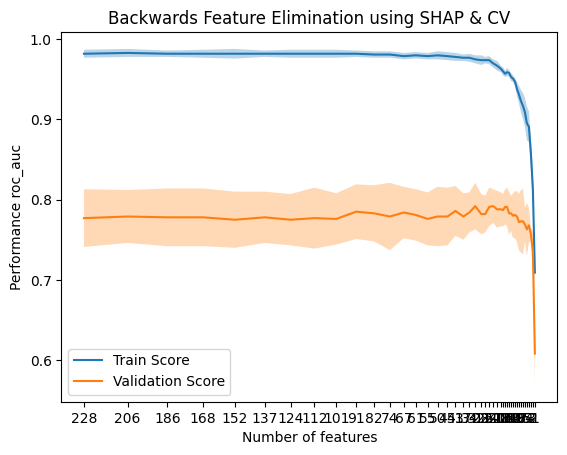

In [18]:
performance_plot = shap_elimination.plot()

In [19]:
report

,num_features,features_set,val_metric_mean
1,228,"[col2341, col2454, col2215, col2456, col2462, ...",0.777
2,206,"[col2341, col2454, col2215, col2456, col2462, ...",0.779
3,186,"[col2341, col2454, col2215, col2456, col2462, ...",0.778
4,168,"[col2341, col2454, col2215, col2456, col2462, ...",0.778
5,152,"[col2341, col2454, col2215, col2456, col2462, ...",0.775
6,137,"[col2341, col2454, col2215, col2456, col2462, ...",0.778
7,124,"[col2341, col2454, col2215, col2456, col2462, ...",0.775
8,112,"[col2341, col2454, col2215, col2456, col2462, ...",0.777
9,101,"[col2341, col2454, col2215, col2456, col2462, ...",0.776
10,91,"[col2341, col2454, col2215, col2456, col2462, ...",0.785


In [20]:
shap_rfe = report[report['val_metric_mean'] == np.max(report['val_metric_mean'])]['features_set'].tolist()[0]

# Обучение модели

In [21]:
model = lgb.LGBMClassifier(**hyperparams)

In [22]:
model.fit(X_train[shap_rfe], y_train)

LGBMClassifier(colsample_bytree=0.7, is_unbalance=False,
               learning_rate=0.6251425519077248, max_depth=5, metric='AUC',
               n_estimators=50, n_jobs=-1, objective='binary', random_state=25,
               reg_alpha=6, reg_lambda=169, silent='warn', verbose=-1)

# Метрики

In [23]:

roc_auc = roc_auc_score(y_test, model.predict_proba(X_test[shap_rfe])[:, 1])
print(roc_auc)

0.8436233239787965


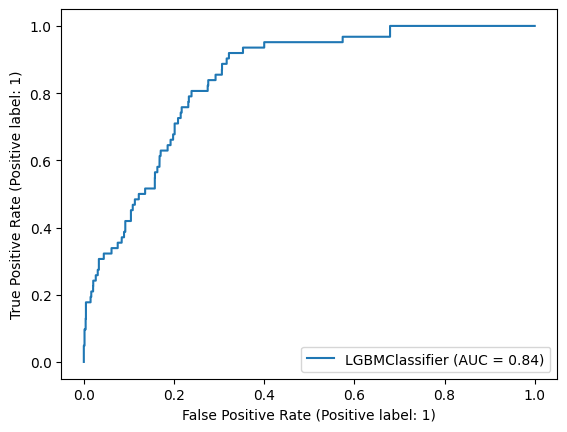

In [24]:


metrics.plot_roc_curve(model, X_test[shap_rfe], y_test)

plt.show()

In [25]:
precision, recall, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test[shap_rfe])[:, 1])
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)

0.16595107773347467


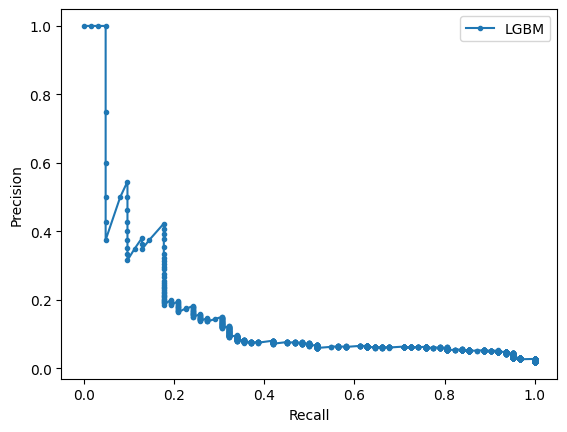

In [26]:
def plot_pr_curve(test_y, model_probs):
    precision, recall, _ = precision_recall_curve(test_y, model_probs)
    plt.plot(recall, precision, marker='.', label='LGBM')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()
plot_pr_curve(y_test, model.predict_proba(X_test[shap_rfe])[:, 1])

<BarContainer object of 21 artists>

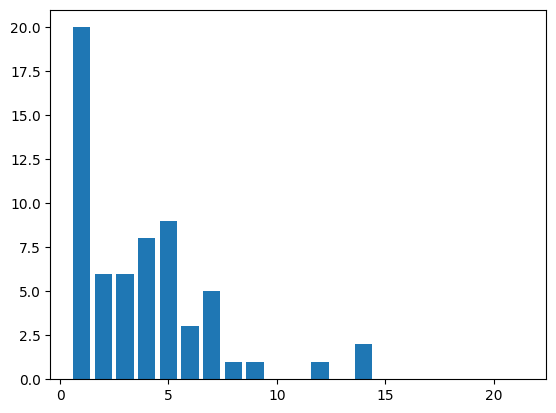

In [27]:
hist_df = pd.DataFrame(
    {
        'target':y_test.values,
        'proba':model.predict_proba(X_test[shap_rfe])[:, 1]
    }
)
hist_df = hist_df.sort_values(by='proba', ascending=False)

num_segments = 20
segment_length = len(hist_df) // num_segments

array_21 = [21]*(len(hist_df)-num_segments*segment_length)
hist_df['segment'] = list(np.repeat(range(1, num_segments + 1), segment_length)) + array_21

hist_df = hist_df.groupby('segment')['target'].sum()
plt.bar(list(hist_df.index), list(hist_df.values))

In [28]:


explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test[shap_rfe])

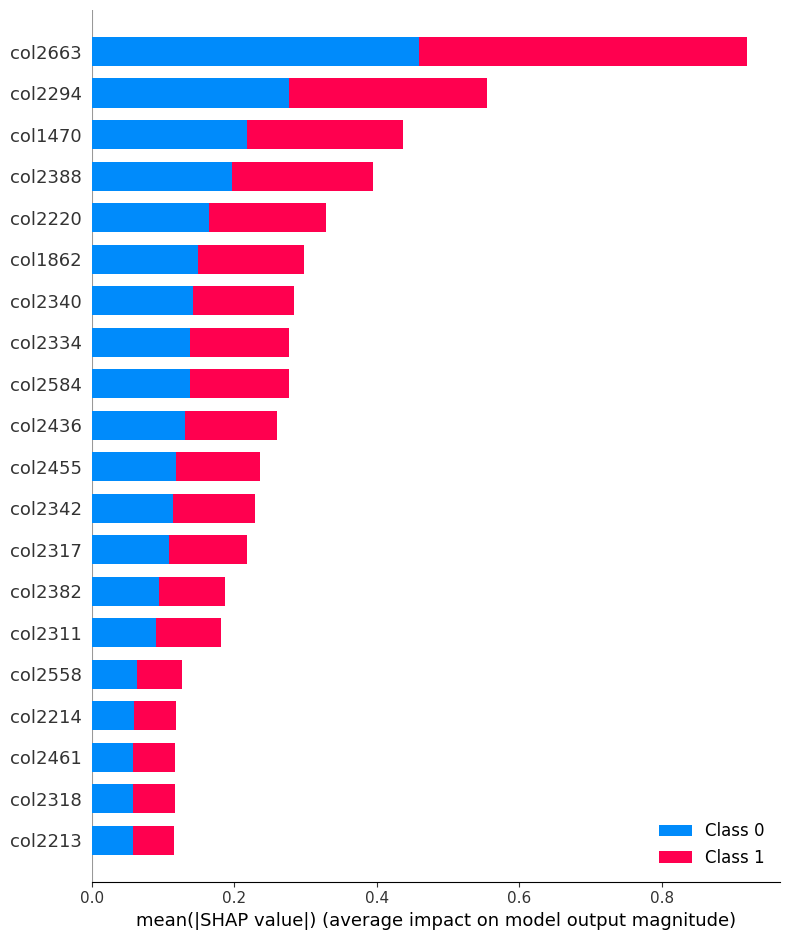

In [29]:
shap.summary_plot(shap_values, X_test[shap_rfe])

# Загрузка в MLflow

In [31]:
os.environ['MLFLOW_S3_ENDPOINT_URL'] = 'http://161.35.150.68:9000'
os.environ["AWS_ACCESS_KEY_ID"] = "6owG9ybVXncQyUFCu7eTEn_mteDf12aAKUgkqLJj76e2V5Yz7NxlVSJnly5dfPH-InWnHdBru062ABgJRU2Z0A"
os.environ["AWS_SECRET_ACCESS_KEY"] = "Gh85cb1UQ2vWO1AvRl9Dld94gKluLnBnvC-tCfSntBikx_A_dD4G842d7RejjDR6BTH0Ko2qaWidswbjm_at4Q"
os.environ["MLFLOW_TRACKING_URI"] = "http://161.35.150.68:5000"

mlflow.set_experiment(experiment_name=f'pavel_test')
client = MlflowClient()

In [33]:


# Data to be written
columns_dict = {'columns': shap_rfe.tolist()}

with open("/content/artifacts/columns.json", "w") as outfile:
    json.dump(columns_dict, outfile)


In [34]:
predictions  = model.predict(X_test[shap_rfe])
signature = infer_signature(X_test[shap_rfe], predictions)
metrics_to_mlflow = {
    'pr_auc':auc_precision_recall,
    'roc_auc':roc_auc
}

with mlflow.start_run(run_name=f'pavel_test8'):
    mlflow.log_params(hyperparams)
    # mlflow.log_param('columns', list(X_test[selection_rfe].columns))
    mlflow.log_param('null_thresh', null_thresh)
    mlflow.log_param('mode_thresh', mode_thresh)
    mlflow.log_param('gini_thresh', gini_thresh)
    mlflow.log_metrics(metrics_to_mlflow)
    mlflow.sklearn.log_model(
        model,
        signature=signature,
        registered_model_name=f'LGBM',
        artifact_path=''
    )
    mlflow.set_tags({'model': 'lgbm'})

    mlflow.log_artifacts('/content/artifacts')
    print(f'Model saved in run {mlflow.active_run().info.run_uuid}')
mlflow.end_run()

2023/09/09 19:09:32 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpdz5vg78a/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.1.3', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
Registered model 'LGBM' already exists. Creating a new version of this model...
2023/09/09 19:09:35 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: LGBM, version 8
Created version '8' of model 'LGBM'.


Model saved in run 98077ad0dc5f40c2acf14aeee219f7c1
